In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import numpy.random as random
import scipy.io, scipy.interpolate
import matplotlib.pyplot as plt
import load_data

## Notation

* $\theta$: the parameters we're trying to infer; in David's model, that's either the accumulation or velocity scaling factors
* $\phi$: the "momentum", you'll see what I mean in a bit
* $P(\theta)$: the probability density function of the parameters
* $\tau$: a fictitious, made-up time (ex: the lifespan of RBG, clearly she's immortal)

## Review & motivation

Say we want to sample from some probability density $P(\theta)$.
There are two parts to MCMC sampling:

* The **transition probability** $Q(\theta_{k + 1} | \theta_k)$: given a state $\theta_k$, the next candidate $\theta_{k + 1}$ is generated by sampling from $Q(\theta | \theta_k)$.
* The **accept/reject** criterion: accept $\theta_{k + 1}$ with probability $\min(1, P(\theta_{k + 1})/P(\theta_k))$.

Usually, $Q(\theta_{k + 1} | \theta_k)$ = normal distribution with mean $\theta_k$.
But this choice is arbitrary and we could use anything, so long as the transitions are reversible: $Q(\theta' | \theta) = Q(\theta | \theta')$.

**Hamiltonian Monte Carlo is a clever choice of transition probability.**
Rather than try to guess randomly where to go from the current parameters, HMC uses information from the contours/gradient of the density $P$ (really $-\log P$) to guide the search.

Lots of algorithms (stochastic gradient descent, simulated annealing, etc.) go down-gradient to find modes of $P$.
This is essentially like solving the ODE

$$\frac{d}{d\tau}\theta - \nabla\log P = 0.$$

The solutions of this ODE as the fictitious time $\tau$ goes to $\infty$ go to extrema.
As we've seen this tends to get stuck in local extrema and you need tricks to make it explore everywhere.
HMC instead uses a second-order ODE

$$\frac{d^2}{d\tau^2}\theta - \nabla\log P = 0$$

to make the guesses oscillate around the modes.

## Hamiltonian mechanics

**Hamiltonian mechanics** is a particular way of describing classical physical systems.

* **The players**: position $\theta$, momentum $\phi$, and the total energy $H(\theta, \phi)$ of the system
* **The rules**: Hamilton's equations of motion,
$$\begin{align}
\dot \theta & = +\frac{\partial H}{\partial \phi} \\
\dot \phi & = -\frac{\partial H}{\partial \theta}
\end{align}$$
* When $\phi = m\dot \theta$, and $H = $ kinetic energy + potential energy, Hamilton's equations of motion are equivalent to Newton's.

Some very important things:
* The energy $H$ is conserved along trajectories of the ODE.
* The volume in phase space is conserved.
Take a "blob" $D$ of position/momentum pairs, now evolve them all for a time $\tau$ using Hamilton's equations; this gives a morphed blob, $D_\tau$.
Then $\mathrm{vol}(D) = \mathrm{vol}(D_\tau)$.
* Hamiltonian dynamics is *reversible* -- flipping all the momenta $\Leftrightarrow$ going backwards in time.

## Hamiltonian Monte Carlo

MCMC simulation works with any reversible transition kernel.
The idea of HMC is to augment the state $\theta$ with a *pseudo-momentum* variable $\phi$ and use Hamiltonian dynamics to update both $\theta$ and $\phi$.

The algorithm:

0. Pick a starting parameter $\theta_0$ however you like.
1. Pick a starting momentum $\phi_0$ sampled from a normal distribution.
2. Solve Hamilton's equation's of motion up to some time $\tau$.
3. Accept/reject the new state $\theta_\tau, \phi_\tau$ according to the usual MCMC criterion:
$$\min\{1, \exp\left[H(\theta_0, \phi_0) - H(\theta_\tau, \phi_\tau)\right]\}$$
4. Throw out the momentum and go back to (1).

If we were able to solve Hamilton's equations exactly, the energy would be conserved and we would always accept the new state!

You can think of HMC as a way to sample from the PDF at two distinct levels at each step.
* Random magnitude of $\phi$ $\Rightarrow$ sampling *across* energy contours.
* Random direction of $\phi$ + solving Hamilton's equations $\Rightarrow$ sampling *along* energy contours.

## Some real data

Let's try and apply this to David's data from last week.
We're going to do a little more cleaning up to remove duplicate points.

In [1]:
x, dx, target_layers, target_ages, a, u = load_data.load()
target_layer = target_layers[-1, :]
timestep_target = 17  # This is our target year spacing

t_ages = target_ages
t_layers = target_layers

times = np.flip(-np.hstack([np.linspace(0, t_ages['Age'][1], int(np.round(t_ages['Age'][0] / timestep_target)) + 1)[:-1]] +
                  [np.linspace(t_ages['Age'][i], t_ages['Age'][i + 1], int(np.round((t_ages['Age'][i + 1] - t_ages['Age'][i]) / timestep_target)) + 1)[:-1] for i in range(len(t_ages) - 1)] +
                  [np.array(t_ages['Age'][-1])]))
compare_indices = np.array([i for i in range(len(times)) if np.any(times[i] == -t_ages['Age'])])
timesteps = np.diff(times)
num_steps = len(timesteps)

NameError: name 'load_data' is not defined

Given the present-day accumulation rate $a(x)$, ice velocity $u(x)$, and the scaling factors $s_a(t)$, $s_u(t)$, David's model for the layer depth $z$ is the solution of the advection equation

$$\frac{\partial z}{\partial t} - s_u(t)u(x)\frac{\partial z}{\partial x} = s_a(t) \cdot DJ(a, z),$$

$$\frac{\partial z}{\partial x}\Big|_{x = L} = 0.$$

up to the final time $t_f$, where $DJ$ is the Dansgaard-Johnsen model for the vertical velocity.
David used an arbitrary Lagrangian-Eulerian scheme to solve these equations.

**One of the hard parts of using HMC is calculating derivatives of the objective w.r.t. the parameters.**
To be able to calculate derivatives, I had to use a more old-fashioned backward Euler integration scheme to solve the model physics.
I calculated the derivatives using the adjoint method.
The derivatives were very inaccurate without a small timestep.

/Users/dlilien/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


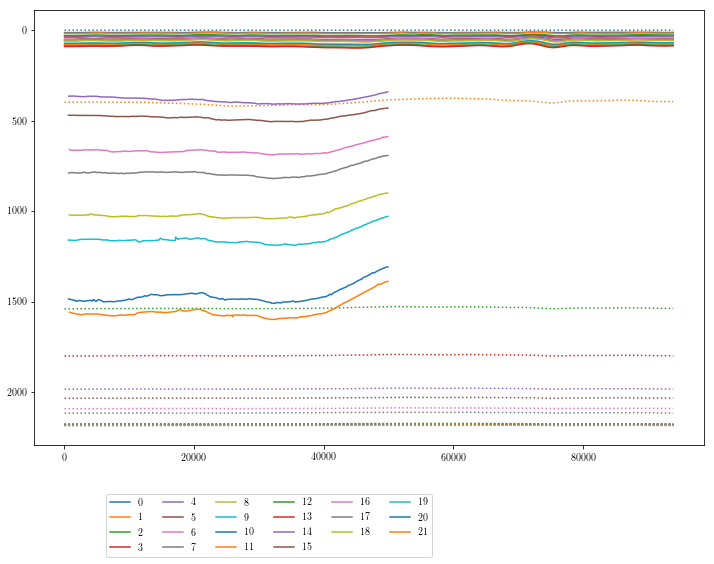

In [3]:
import model

accumulation_scale = 1.5 * np.ones(num_steps)
accumulation_good_guess = np.array([1.93, 1.91, 1.87, 1.88, 1.86, 1.861, 1.83, 1.76, 1.73, 1.75, 1.70, 1.66, 1.66, 1.66, 1.63, 1.50, 1.48,  1.44, 1.43,  1.340, 1.37, 1.37,  1.36, 1.38, 1.35, 1.35, 1.34, 1.32, 1.28, 1.26, 1.26,  1.30, 1.31, 1.26, 1.23, 1.20, 1.23,  1.25, 1.21, 1.22, 1.22, 1.21])
velocity_scale = 1.05 * np.ones(num_steps)

z = model.layer_depth(x, accumulation_scale, velocity_scale,
                      a, u, timesteps)
# We are going to do this to see how we are doing at every layer
# It should give us a good idea of whether dJ_da should be positive
plt.figure(figsize=(12, 8))
for i, index in enumerate(compare_indices):
    ln = plt.plot(x, z[index], linestyle='dotted')
    plt.plot(x, t_layers[i, :], color=ln[0].get_color(), linestyle='solid', label=str(i))
    plt.legend(loc='upper left', bbox_to_anchor=(0.1, -0.1), ncol=6)
plt.gca().invert_yaxis()

The figure below shows the sensitivity of the mean-square error to changes in the accumulation scale over time.

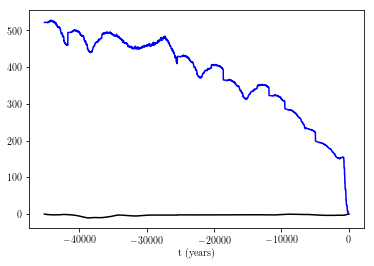

In [4]:
dJ_da = model.derivative_scales(x, accumulation_scale, velocity_scale,
                                a, u, z, t_layers,
                                compare_indices, timesteps)

fig, ax = plt.subplots()
ax.plot(times[:-1], dJ_da[:len(times[:-1])], color='b')
ax.plot(times[:-1], dJ_da[len(times[:-1]):], color='k')

ax.set_xlabel('t (years)')
plt.show(fig)

Next, let's compute the expected decrease in the mean-square error, assuming that we perturbed the accumulation scale by going down-gradient.

To make sure I implemented everything right, we can calculate the actual decrease in the error and see how well it agrees with the value `dJ` computed above.

## Skeleton of HMC

We now have everything in place to start sampling from the PDF for David's data and model!

In order to make the runs reproducible, we'll use a `RandomState` object from numpy for all our random number generation.
If some run is particularly interesting, we can serialize the random state object, save it to disk, and deserialize it later when we want to reproduce the run identically.
This involves some extra book-keeping but you should always do it.

In [5]:
random_state = random.RandomState()

Last week, we discussed using regularization in order to select for smooth values of the parameters; this is equivalent to a certain choice of prior in Bayesian inference.
We'll do the same thing this time.
**How you regularize the problem determines the choice of mass matrix**, i.e. how the different components of the momentum vector are coupled together.

Note how we divide by the square root of the number of time steps to get the right total variance.

In [6]:
r = 20
import scipy.sparse, scipy.sparse.linalg, numpy.linalg
two_step = np.hstack((timesteps, timesteps))
Id = scipy.sparse.diags([np.ones(num_steps * 2)], [0])
D = scipy.sparse.diags([1. / two_step, -1. / two_step], [0, 1], shape=(len(two_step) - 1, len(two_step)))
L = r**2 * D.T * D * np.mean(timesteps)
D2 = scipy.sparse.diags([1. / timesteps, -1. / timesteps], [0, 1], shape=(len(timesteps) - 1, len(timesteps)))
L2 = r**2 * D2.T * D2 * np.mean(timesteps)
M = Id + L

λs, vs = numpy.linalg.eigh(M.toarray())

def generate_momentum(random_state, σ):
    ζ = random_state.normal(size=num_steps * 2)
    return sum(((ζ[k] * np.sqrt(λs[k] / (num_steps * 2)) * σ) * vs[:, k] for k in range(2 * num_steps)))

The following functions calculate each part of the Hamiltonian and its derivatives.
The final term in the potential -- `np.dot(θ, L * θ)` -- is what adds the penalty for oscillatory solutions.

In [7]:
def potential_energy(θ_a, θ_v):
    z_θ = model.layer_depth(x, θ_a, θ_v, a, u, timesteps)
    return np.sum(model.msm(x, z_θ[compare_indices,:], t_layers) + 0.5 * np.dot(θ_a, L2 * θ_a) + 0.5 * np.dot(θ_v, L2 * θ_v))

def kinetic_energy(ϕ):
    return 0.5 * np.dot(ϕ.flatten(), scipy.sparse.linalg.spsolve(M, ϕ))

def force(θ_a, θ_v):
    z_θ = model.layer_depth(x, θ_a, θ_v, a, u, timesteps)
    return -model.derivative_scales(x, θ_a, θ_v, a, u, z_θ, t_layers, compare_indices, timesteps) - np.hstack((L2 * θ_a, L2 * θ_v))

def velocity(ϕ):
    return scipy.sparse.linalg.spsolve(M, ϕ)

This function implements the Verlet method for numerically integrating a Hamiltonian system.

In [8]:
def hamiltonian_update(δτ, θ_a, θ_v, ϕ):
    vel = velocity(ϕ)
    θ_a_τ  = θ_a + 0.5 * δτ * vel[:len(θ_a)]
    θ_v_τ  = θ_v + 0.5 * δτ * vel[len(θ_a):]

    ϕ_τ = ϕ + δτ * (force(θ_a_τ, θ_v_τ))
    
    vel = velocity(ϕ_τ)
    θ_a_τ += 0.5 * δτ * vel[:len(θ_a)]
    θ_v_τ += 0.5 * δτ * vel[len(θ_a):]
    
    return θ_a_τ, θ_v_τ, ϕ_τ 

Create the initial parameter and momentum and plot the velocity.
The initial kinetic energy should be around 0.5 (it's a $\chi^2$ random variable).

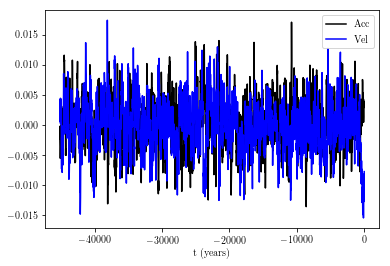

In [9]:
θ_a = accumulation_scale.copy()
θ_v = velocity_scale.copy()

ϕ = generate_momentum(random_state, 1)

fig, ax = plt.subplots()
ax.plot(times[1:], velocity(ϕ)[:len(times[1:])], color='k', label='Acc')
ax.plot(times[1:], velocity(ϕ)[len(times[1:]):], color='b', label='Vel')

ax.set_xlabel('t (years)')
plt.legend()
plt.show(fig)

Solve the system using a fictitious timestep of 1/32 for 2/3 of a fictitious time unit.
I had to hand-tune both of these parameters to get something sensible.

In [ ]:
δτ = 1.0/32
num_hamiltonian_steps = int(3.0 / 4 / δτ)

for k in range(num_hamiltonian_steps):
    θ_a, θ_v, ϕ = hamiltonian_update(δτ, θ_a, θ_v, ϕ)
    print(kinetic_energy(ϕ), potential_energy(θ_a, θ_v))

203663.0279776859 2334447537891.8193
1250518.646744805 1019189715135.7395
2309409.1503110817 5781697912788.6875
8098864106.605523 3907748534730.7925
8098862612.849275 3910635883433.6313


/Users/dlilien/work/mc/glaciology-seminar-2018-10-16/model.py:70: RuntimeWarning: invalid value encountered in add
  f = z[step, :] + timesteps[step] * vertical_velocity(a_scale[step] * a, z[step, :])
/Users/dlilien/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


8098859736.271842 1878737678202.7349
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan


Compute a few statistics of the resulting random state.

In [ ]:
fig, ax = plt.subplots()
ax.plot(times[:-1], θ_a, color='k')
ax.plot(times[:-1], θ_v, color='b')

ax.set_xlabel('t (years)')
plt.show(fig)

In [ ]:
print(potential_energy(θ_a, θ_v), potential_energy(accumulation_scale, velocity_scale))

The resulting layer depth undershoots pretty dramatically.

In [ ]:
z_θ = model.layer_depth(x, θ_a, θ_v, a, u, timesteps)

fig, ax = plt.subplots(figsize=(12, 8))
for i, index in enumerate(compare_indices):
    ln = plt.plot(x/1000, z_θ[index], label=str(i))
    ax.plot(x/1000, t_layers[i, :], color=ln[0].get_color(), linestyle='dashed')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, -0.1), ncol=6)
ax.set_xlabel("x (km)")
ax.invert_yaxis()
plt.show(fig)

## HMC sampling

Now let's generate a bunch of samples and see what the resulting ensemble looks like.

In [ ]:
num_samples = 100
θs = np.zeros((num_samples, num_steps))
θs[0, :] = accumulation_scale.copy()
θsv = np.zeros((num_samples, num_steps))
θsv[0, :] = velocity_scale.copy()
for sample in range(1, num_samples):
    print(sample, ':   ', end='')
    ϕ = generate_momentum(random_state, 1)
    θ_a = θs[sample - 1, :].copy()
    θ_v = θsv[sample - 1, :].copy()


    for k in range(num_hamiltonian_steps):
        print('..{:d}'.format(k), end='')
        θ_a, θ_v, ϕ = hamiltonian_update(δτ, θ_a, θ_v, ϕ)
        
    print('')
    print(kinetic_energy(ϕ), potential_energy(θ_a, θ_v))
    print('')
    θs[sample, :] = θ_a.copy()
    θsv[sample, :] = θ_v.copy()

Lighter colors are earlier runs, darker colors are later ones.
We can clearly see the guesses migrating through parameter space.

In [ ]:
cm1 = plt.get_cmap('autumn')
cm2 = plt.get_cmap('winter')


fig, ax = plt.subplots()
for sample in range(num_samples):
    ax.plot(times[1:], θs[sample, :], color=cm1((sample + 1) / num_samples))
    ax.plot(times[1:], θsv[sample, :], color=cm2((sample + 1) / num_samples))

ax.set_xlabel('t (years)')
plt.show(fig)

Despite the differences in the parameter values, the resulting ice layers are very clustered.

In [ ]:
colormap = plt.get_cmap('binary')

fig, ax = plt.subplots()
for i, index in enumerate(compare_indices):
    for sample in range(num_samples):
        θ = θs[sample, :]
        z_θ = model.layer_depth(x, θ, velocity_scale,
                            a, u, timesteps)
        ax.plot(x/1000, z_θ[index, :], color=colormap((sample + 1) / num_samples))
        ax.plot()
    
    ax.plot(x/1000, t_layers[i], color='r')

ax.invert_yaxis()
plt.show(fig)